In [1]:
import litebird_sim as lbs
import numpy as np
import healpy as hp
from dataclasses import asdict
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
nside = 512
mission_time_is_sec = 24 * 3600
instrument = "MFT"
channel = "M1-140"
sampling = 1  # this replaces channelinfo.sampling_rate_hz

In [6]:
imo_version = 'v1.3'
imo = lbs.Imo()
sim = lbs.Simulation(
    base_path="./tutorial",
    start_time=0,
    duration_s=mission_time_is_sec,
)

In [7]:
mft_file = sim.imo.query("/releases/" + imo_version + "/satellite/" + instrument + "/instrument_info")
sim.set_scanning_strategy(imo_url="/releases/" + imo_version + "/satellite/scanning_parameters/")
instrumentinfo = lbs.InstrumentInfo(
    name=instrument,
    boresight_rotangle_rad=np.deg2rad(mft_file.metadata["boresight_rotangle_deg"]),
    spin_boresight_angle_rad=np.deg2rad(mft_file.metadata["spin_boresight_angle_deg"]),
    spin_rotangle_rad=np.deg2rad(mft_file.metadata["spin_rotangle_deg"]),
)

instrumentinfo = lbs.InstrumentInfo.from_imo(
    imo, f"/releases/v1.3/satellite/{instrument}/instrument_info"
)

channelinfo = lbs.FreqChannelInfo.from_imo(
    url="/releases/" + imo_version + "/satellite/" + instrument + "/" + channel + "/channel_info",
    imo=imo,
)
hwp_radpsec = lbs.IdealHWP(
    instrumentinfo.hwp_rpm * 2 * np.pi / 60,
).ang_speed_radpsec

Band is not apodized


In [8]:
dets = []
detquats = []

for detname in channelinfo.detector_names:
    det = lbs.DetectorInfo.from_imo(
        url="/releases/" + imo_version + "/satellite/"
        + instrument
        + "/"
        + channel
        + "/"
        + detname
        + "/detector_info",
        imo=imo,
    )
    det.sampling_rate_hz = sampling
    dets.append(det)
    detquats.append(det.quat)

Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not apodized
Band is not a

## Fill tod and then build map

In [9]:
(obs,) = sim.create_observations(detectors=dets)

(pointings,) = lbs.get_pointings_for_observations(
    sim.observations,
    spin2ecliptic_quats=sim.spin2ecliptic_quats,
    bore2spin_quat=instrumentinfo.bore2spin_quat,
    hwp=None,
    # lbs.IdealHWP(
    #    inst_info.hwp_rpm * 2 * np.pi / 60,
    # ),  # applies hwp rotation angle to the polarization angle
    store_pointings_in_obs=True,  # if True, stores colatitude and longitude in
    # sim.observations[:].pointings, and the polarization angle in
    # sim.observations[:].psi
)

In [10]:
Mbsparams = lbs.MbsParameters(
    make_cmb=True,
    make_fg=False,
    gaussian_smooth=True,
    bandpass_int=False,
    nside=nside,
    maps_in_ecliptic = False,
)

mbs = lbs.Mbs(
    simulation=sim,
    parameters=Mbsparams,
    channel_list=channelinfo,
)
maps = mbs.run_all()[0][channel]

generating and saving cmb simulations


[2023-07-04 07:15:43,417 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2023-07-04 07:15:43,418 INFO MPI#0000] -> fwhm is 0.000000 arcmin


***************** D
***************** D
***************** D


[2023-07-04 07:15:44,040 INFO MPI#0000] Access data from /marconi_work/INF23_indark/nraffuzz/litebird/litebird_sim/litebird_sim/hwp_sys/examples/tutorial/cmb/0000/cmb_0000_date_230704.fits
[2023-07-04 07:15:44,043 INFO MPI#0000] NSIDE = 512
[2023-07-04 07:15:44,044 INFO MPI#0000] ORDERING = RING in fits file
[2023-07-04 07:15:44,045 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-07-04 07:15:47,252 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2023-07-04 07:15:47,253 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2023-07-04 07:15:47,334 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2023-07-04 07:15:47,335 INFO MPI#0000] -> fwhm is 0.000000 arcmin


In [11]:
hwp_sys = lbs.HwpSys(sim)
hwp_sys.set_parameters(
    maps=maps,
    integrate_in_band=False,
    correct_in_solver=False,
    built_map_on_the_fly=False,
    nside=nside,
)

In [12]:
hwp_sys.fill_tod(
    obs=obs,  # pointings = pointings, #optional since we have saved point in obs
    hwp_radpsec=hwp_radpsec,
)
obs.tod *= 2.0  #

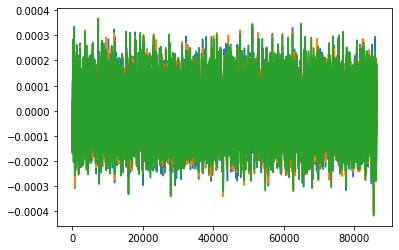

In [13]:
plt.plot(obs.tod[0])
plt.plot(obs.tod[1])

In [16]:
m = lbs.make_binned_map(nside, [obs]).T

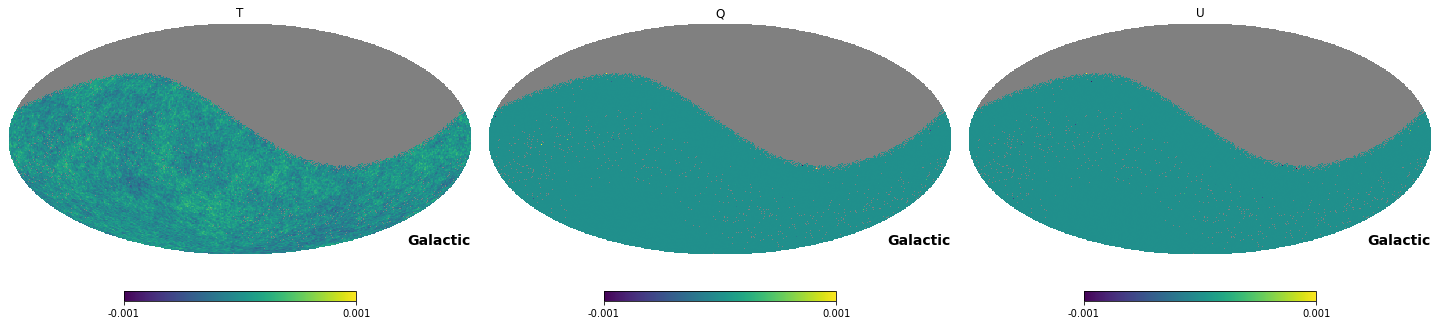

In [18]:
fig = plt.figure(figsize=(20, 10))
hp.mollview(m[0] - maps[0], sub=131, title="T", coord=['G'], min=-1e-3, max=1e-3)
hp.mollview(m[1] - maps[1], sub=132, title="Q", coord=['G'], min=-1e-3, max=1e-3)
hp.mollview(m[2] - maps[2], sub=133, title="U", coord=['G'], min=-1e-3, max=1e-3)

## Built map on the fly

In [19]:
# obs.tod not allocated
(obs,) = sim.create_observations(detectors=dets)

In [20]:
hwp_sys = lbs.HwpSys(sim)
# Here the obs.tod is not filled
hwp_sys.set_parameters(
    maps=maps,
    integrate_in_band=False,
    correct_in_solver=False,
    built_map_on_the_fly=True,
    nside=nside,
)

In [21]:
hwp_sys.fill_tod(obs=obs, pointings=pointings, hwp_radpsec=hwp_radpsec)

In [22]:
m = hwp_sys.make_map([obs])

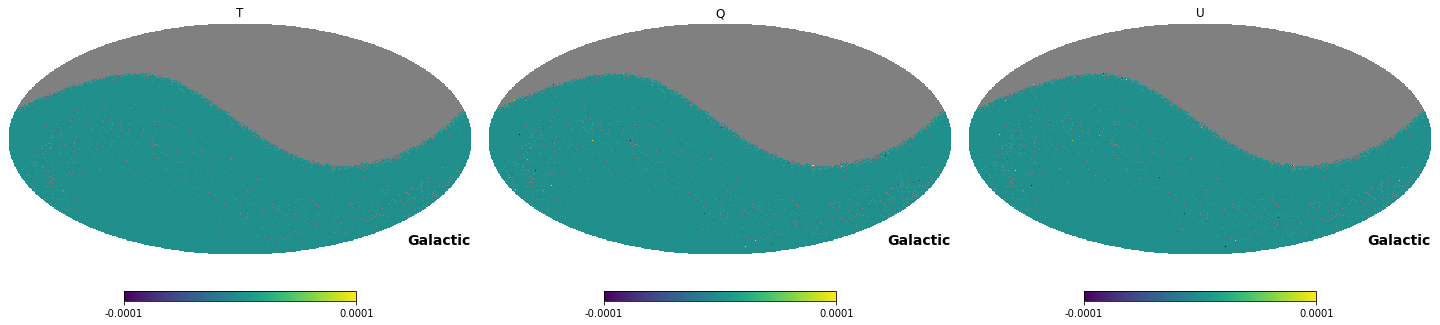

In [24]:
fig = plt.figure(figsize=(20, 10))
hp.mollview(m[0] - maps[0], sub=131, title="T", coord=['E','G'], min=-1e-4, max=1e-4)
hp.mollview(m[1] - maps[1], sub=132, title="Q", coord=['E','G'], min=-1e-4, max=1e-4)
hp.mollview(m[2] - maps[2], sub=133, title="U", coord=['E','G'], min=-1e-4, max=1e-4)